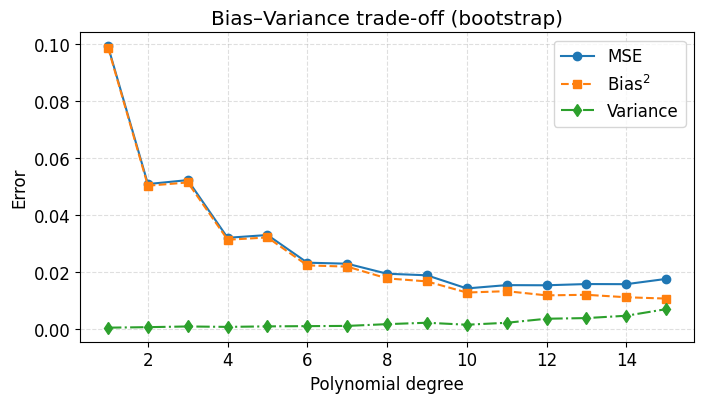

In [11]:
# Bias-variance trade off
import sys, pathlib
import numpy as np
import matplotlib.pyplot as plt

# parent of Notebooks/
proj_dir = pathlib.Path.cwd().parent                  
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))
fig_dir = proj_dir / "Figures"
fig_dir.mkdir(parents=True, exist_ok=True)

# make_data creates a 1D dataset with noise, build_features creates polynomial features
from Code.data import make_data, build_features, split_and_scale

# 200 datapoints with noise, fixed seed for reproducibility
rng = np.random.default_rng(48)
x, y = make_data(n=200, noise_sd=0.12, seed=48)      # shapes (n,1)

idx = rng.permutation(len(x)) #shuffle indices 
n_test = len(x) // 5                                 # 20% test
te, tr = idx[:n_test], idx[n_test:] #split indices into test and train
x_tr, y_tr = x[tr], y[tr] 
x_te, y_te = x[te], y[te] 
#we shuffle so that the data is randomly split into train and test

degrees = range(1, 16) #polynomial degree up to 15
B = 300 #number of bootstrap samples

mse_vals, bias2_vals, var_vals = [], [], []

for d in degrees:
    #  Build polynomial features X for this degree
    X = build_features(x, degree=d, include_bias=False)  # shape (n, d)
    X_tr_s, X_te_s, y_tr_c, y_te, scaler, y_mu = split_and_scale(
        X, y, test_size=0.2, random_state=48, center_y=True
    )   

    #y_tr_c is centered (mean subtracted); X_tr_s, X_te_s are scaled (std and mean)
   #y_mu is the mean of y_tr, used to restore intercept later

    # Bootstrap OLS on training; predict the fixed testing
    preds = np.empty((B, len(y_te))) 
    ntr = len(y_tr_c)                          # number of training points
    for b in range(B): 
        bi = rng.integers(0, ntr, size=ntr)            # sample training rows with replacement
        theta, *_ = np.linalg.lstsq(X_tr_s[bi], y_tr_c[bi], rcond=None) #OLS on bootstrap sample
        preds[b] = (X_te_s @ theta + y_mu).ravel()     # add back mean to restore intercept

    # Compute bias^2, variance, and MSE of the predictions
    pm = preds.mean(axis=0)                            # mean prediction over bootstraps
    pv = preds.var(axis=0)                             # per-point variance over bootstraps
    bias2_vals.append(np.mean((y_te.ravel() - pm)**2)) # squared bias
    var_vals.append(np.mean(pv))                    # variance
    mse_vals.append(np.mean((y_te.ravel() - preds)**2)) # MSE


plt.rcParams.update({'font.size': 12}) #larger font size for better readability
fig, ax = plt.subplots(figsize=(7.2, 4.2)) 
ax.plot(list(degrees), mse_vals,   'o-', label='MSE')
ax.plot(list(degrees), bias2_vals, 's--', label='Bias$^2$')
ax.plot(list(degrees), var_vals,   'd-.', label='Variance')
ax.set_xlabel('Polynomial degree')
ax.set_ylabel('Error')
ax.set_title('Bias–Variance trade-off (bootstrap)')
ax.grid(True, ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
fig.savefig(fig_dir / "bias_variance_tradeoff.png", dpi=300)
plt.show()


